# Skin Cancer Detection and Classification with Deep Learning

#### CAPSTONE PROJECT for Applied Data Science and Machine Learning Course   
#### Pawel Rosikiewicz   
#### prosikiewicz@gmail.com

In [1]:
# *********************************************************** #
#                                                             #
#    Copyrights:                                              # ivbju
#                                                             #
#    IT IS NOT ALLOWED TO COPY, DISTRIBUTE                    # 
#    in any form of these files, scripts, methods,            # 
#    data and results without written persmission             #
#    of the Author                                            #
#                                                             #
#    Author: Pawel Rosikiewicz                                #
#    Contact: prosikiewicz_gmail.com                          #
#                                                             #
# *********************************************************** #

# standard imports

In [1]:
import os # allow changing, and navigating files and folders, 
import shutil
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf # tf.__version__ 
import tensorflow.keras as keras 
import matplotlib.pyplot as plt # for making plots, 
import scipy.stats as stats  # library for statistics and technical programming, 
import scipy.cluster.hierarchy as sch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from tensorflow.keras import backend as K # used for housekeeping of tf models,
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
# To avoid restaring the kernel with keras, preffered solution; use conda install nomkl
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# setup basedir & load project/task imports

In [2]:
# setup basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

# caution, loaded only form basedir,
import src.utils.EDA_Helpers2 as eda_helpers 
from src.utils.example_plots import *
from src.utils.feature_extraction_tools import encode_images_with_tfhubmodule # with tf.compat.v1 functions, for tf.__version___ >= 1.15
from src.utils.clustered_histogram import find_n_examples_in_each_class, clustered_histogram_with_image_examples, calculate_linkage_for_images_with_extracted_features
from src.utils.clustered_histogram import add_descriptive_notes_to_each_cluster_in_batch_labels, find_clusters_on_dendrogram, create_clustered_heatmap_with_img_examples
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.feature_extraction_tools import encode_images
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba, plot_examples_with_predictions_and_proba_gamma
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.knn_tools import knn_grid_search
from src.utils.image_augmentation import *
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.pca_tools import pca_analyis_with_plots, pca_scree_plots, pca_pve_vs_variance_scatterplots
from src.utils.new_data_loaders import find_different_filetypes
from src.utils.sklearn_models_tools import sklearn_grid_search
from src.utils.method_comparison_tools import boxplot_with_acc_from_different_models
from src.utils.method_comparison_tools import method_comparison_boxplot
from src.utils.cnn_transfer_learning_tools import CNN_GridSearch, create_keras_two_layer_dense_model, plot_NN_loss_acc
from src.utils.method_comparison_tools import new_method_comparison_boxplot
warnings.filterwarnings("ignore")

# configs

In [3]:
# load project configs
from src.configs.project_configs import PROJECT_NAME
from src.configs.project_configs import CLASS_DESCRIPTION # information on each class, including descriptive class name and diegnostic description - used to help wiht the project
from src.configs.tfhub_configs import TFHUB_MODELS # names of TF hub modules that I presenlected for featuress extraction with all relevant info,
from src.configs.dataset_configs import DATASET_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import CLASS_LABELS_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import DROPOUT_VALUE # str, special value to indicate samples to remoce in class labels
from src.configs.config_functions import CONFIG_FUNCTION_define_datasets # function that creates datasunbsets collections for one dataset (custome made for that project)

# set task configs, ........................................................................  
TASK_NAME                  = "SUMMARY_models_comparison"
DATASET_NAME               = "HAM10000" # dataset name, 
DATASET_VARIANTS           = DATASET_CONFIGS[DATASET_NAME]["labels"] # labels that will be added here
MODULE_NAMES               = [TFHUB_MODELS[x]['module_name'] for x in list(TFHUB_MODELS.keys())]

# set run configs, ........................................................................   
METHOD_NAME_LIST           = ["knn", "random_forest", "svm", "cnn_transfer_learning", "deNovoCNN"]
METHOD_GROUPS              = ["sklearn_model", "sklearn_model", "sklearn_model", "cnn", "cnn"]
DATASET                    = ["HAM10000", "HAM10000", "HAM10000", "HAM10000", "HAM10000_balanced"]
BATCH_COLLECTION_NAMES     = {"HAM10000": { "boxpot":["parameter_selection", 'cnn_all_data'],
                                            "scatter":["best_models_with_all_data", "full_models"]
                              }}

# create path to store results, ............................................................
PATH_raw = os.path.join(basedir, "data/raw", DATASET_NAME)
PATH_interim = os.path.join(basedir, "data/interim")
PATH_models = os.path.join(basedir, "models")
PATH_interim_dataset_summary_tables = os.path.join(PATH_interim, "dataset_summary_tables")
PATH_extracted_features = os.path.join(PATH_interim, f"{DATASET_NAME}_extracted_features")
PATH_additional_class_labels = os.path.join(PATH_extracted_features, "additional_class_labels")
PATH_data_results = os.path.join(basedir, "data/results")
PATH_results = os.path.join(PATH_data_results, f"{DATASET_NAME}_{TASK_NAME}")

# build summary table with results from all methods, varinats and models,
---

In [44]:
######### PART 1A ........ LOAD ALL DATA 

os.chdir(PATH_data_results)
counter = -1
for i, one_method_name in enumerate(METHOD_NAME_LIST):
    
    # go to directory, 
    methods_results_path = os.path.join(PATH_data_results,f"{DATASET_NAME}_{one_method_name}")
    os.chdir(methods_results_path)

    # catalog all files inside 
    file_list = []
    for file in glob.glob("*__summary_table.csv"):
        file_list.append(file)
    
    # info
    print("\n", i, one_method_name, ": ",len(file_list), " files witll be added...\n")
        
    # load and concatenate all of them
    for file_name in file_list:
        counter+=1
        
        # .. load summary_df, and add filename and path
        one_module_summary_df = pd.read_csv(file_name)
        one_module_summary_df["summary_table__file_name"] = file_name
        one_module_summary_df["summary_table__path"] = methods_results_path
        
        # ... concatenate
        if counter==0:
            summary_df = one_module_summary_df 
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)    
        
        # ... info
        # print(f"- {counter} - {file_name} - {summary_df.shape}")    
summary_df.reset_index(drop=True, inplace=True)
print(summary_df.shape)


######### PART 1B ........ CUSTOM CLEANING
problematic_columns = ['validation_split'] # with no usefull data, typically infherrited from params, 
for pc in problematic_columns:
    try:
        summary_df = summary_df.drop('validation_split', axis=1)
    except:
        print(pc, " - not found")
summary_df.shape


# in one of my fucntions, baseline was a smallest proportion, 
# it is being corrected here (I checked it by hand in excel using batch labels)
baseline_missing = summary_df.summary_table__file_name.str.contains("deNovoCNN")
one_different_dataset_variant = summary_df.summary_table__file_name.str.contains("Cancer_Classification")

# .. now replace
summary_df.baseline_acc_valid.loc[baseline_missing] = 0.372  # its balanced,
summary_df.baseline_acc_test.loc[baseline_missing] = 0.628  # these are same as inbalanced datasets, 
summary_df.baseline_acc_test_2.loc[baseline_missing] = 0.617
# ....
summary_df.baseline_acc_valid.loc[baseline_missing & one_different_dataset_variant] = 0.336
summary_df.baseline_acc_test.loc[baseline_missing & one_different_dataset_variant] = 0.351
summary_df.baseline_acc_test_2.loc[baseline_missing & one_different_dataset_variant] = 0.348


# remove one corrupted file
print(summary_df.shape)
files_to_remove = summary_df.summary_table__file_name.str.contains("unit_test") # I accidentally left one file like that
summary_df = summary_df.loc[files_to_remove==False, :]
summary_df.reset_index(drop=True, inplace=True)



######### PART 1C ........ add informative method name

# add column with method_group, 
summary_df["method_name"] = [f"{x}, {y} ({z})" for (x,y, z) in zip(
                                 summary_df.loc[:,"method"].values.tolist(),
                                 summary_df.loc[:, "method_variant"].values.tolist(),
                                 summary_df.loc[:, "module"].values.tolist(),
                                 )]
summary_df["method_full_name"] = [f"{x}__{y}__{z}__{zz}" for (x,y,z,zz) in zip(
        summary_df.loc[:,"method"].values.tolist(),
        summary_df.loc[:, "method_variant"].values.tolist(),
        summary_df.loc[:, "module"].values.tolist(),
        summary_df.loc[:, "dataset_variant"].values.tolist()        
    )]
summary_df.reset_index(drop=True, inplace=True)
summary_df.shape


 0 knn :  60  files witll be added...


 1 random_forest :  60  files witll be added...


 2 svm :  31  files witll be added...


 3 cnn_transfer_learning :  24  files witll be added...


 4 deNovoCNN :  12  files witll be added...

(2667, 59)
(2667, 58)


(2666, 60)

# CALULATE SENSITIVITY FOR DETECTING MELANOMA OR POTENTIAL MELANOMA WITH EACH MODEL
---

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

STAT_RESULTS = []
for row_nr in range(summary_df.shape[0]):
    print(".", end="")
    
    # (a) get required info
    model_ID                 = summary_df.model_ID.iloc[row_nr]
    dataset_variant          = summary_df.dataset_variant.iloc[row_nr]
    summary_table__file_name = summary_df.summary_table__file_name.iloc[row_nr]
    summary_table__path      = summary_df.summary_table__path.iloc[row_nr]
    
    # (b) get model predicitons,
    
    # .. load model predictions for that model
    model_predictions__file_name = pd.Series(summary_table__file_name).str.replace("summary_table.csv", "model_predictions_dict.p").iloc[0]
    
    # .. Load predictions, 
    os.chdir(summary_table__path )
    with open(model_predictions__file_name, 'rb') as file: 
        model_predictions_dict  = pickle.load(file)  

    # .. get predicitons made only for that one model
    one_model_predictions_dict = model_predictions_dict[model_ID]
    
    
    # (c) get labels for a given dataset variant
    '''
        POSITIVE == Melanola, or class containing melanoma
        NEGATIVE == not melanoma, or class not containign melanoma
    '''
    melanoma_stat_labels_dict = CLASS_LABELS_CONFIGS[dataset_variant]['melanoma_stat_labels_dict']
    mel_dict_binary = {"NEGATIVE":0, "POSITIVE":1}
    
    
    # (d) calculate statistics
    one_model_STAT_RESULTS = dict()
    for one_subset_name in ["test", "test_2"]:
        
        # get labels and predictions
        y_true      = one_model_predictions_dict[one_subset_name]['original_labels']
        y_pred      = one_model_predictions_dict[one_subset_name]['model_predictions']

        # map new labels, 
        mel_y_true  = pd.Series(y_true).map(melanoma_stat_labels_dict) 
        mel_y_pred  = pd.Series(y_pred).map(melanoma_stat_labels_dict)
   
        # calculate some stats
        STATS_precision_score = precision_score(mel_y_true.map(mel_dict_binary), mel_y_pred.map(mel_dict_binary))
        STATS_recall_score = recall_score(mel_y_true.map(mel_dict_binary), mel_y_pred.map(mel_dict_binary))
        STATS_f1_score = f1_score(mel_y_true.map(mel_dict_binary), mel_y_pred.map(mel_dict_binary))
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
        
        # store the results
        one_model_STAT_RESULTS[f"STATS_precision_score_{one_subset_name}"] = STATS_precision_score
        one_model_STAT_RESULTS[f"STATS_recall_score_{one_subset_name}"] = STATS_recall_score
        one_model_STAT_RESULTS[f"STATS_f1_score_{one_subset_name}"] = STATS_f1_score
        
    # (e) add to main list
    STAT_RESULTS.append(one_model_STAT_RESULTS)
        


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [50]:
# add STAT_RESULTS to summary df
print(summary_df.shape)
summary_df_with_stats = pd.concat([summary_df, pd.DataFrame(STAT_RESULTS)], axis=1)
summary_df_with_stats.shape

# go to results directory and save the file,


(2666, 60)


(2666, 66)

# Grid Search on parameters

# Evaluate the results
---

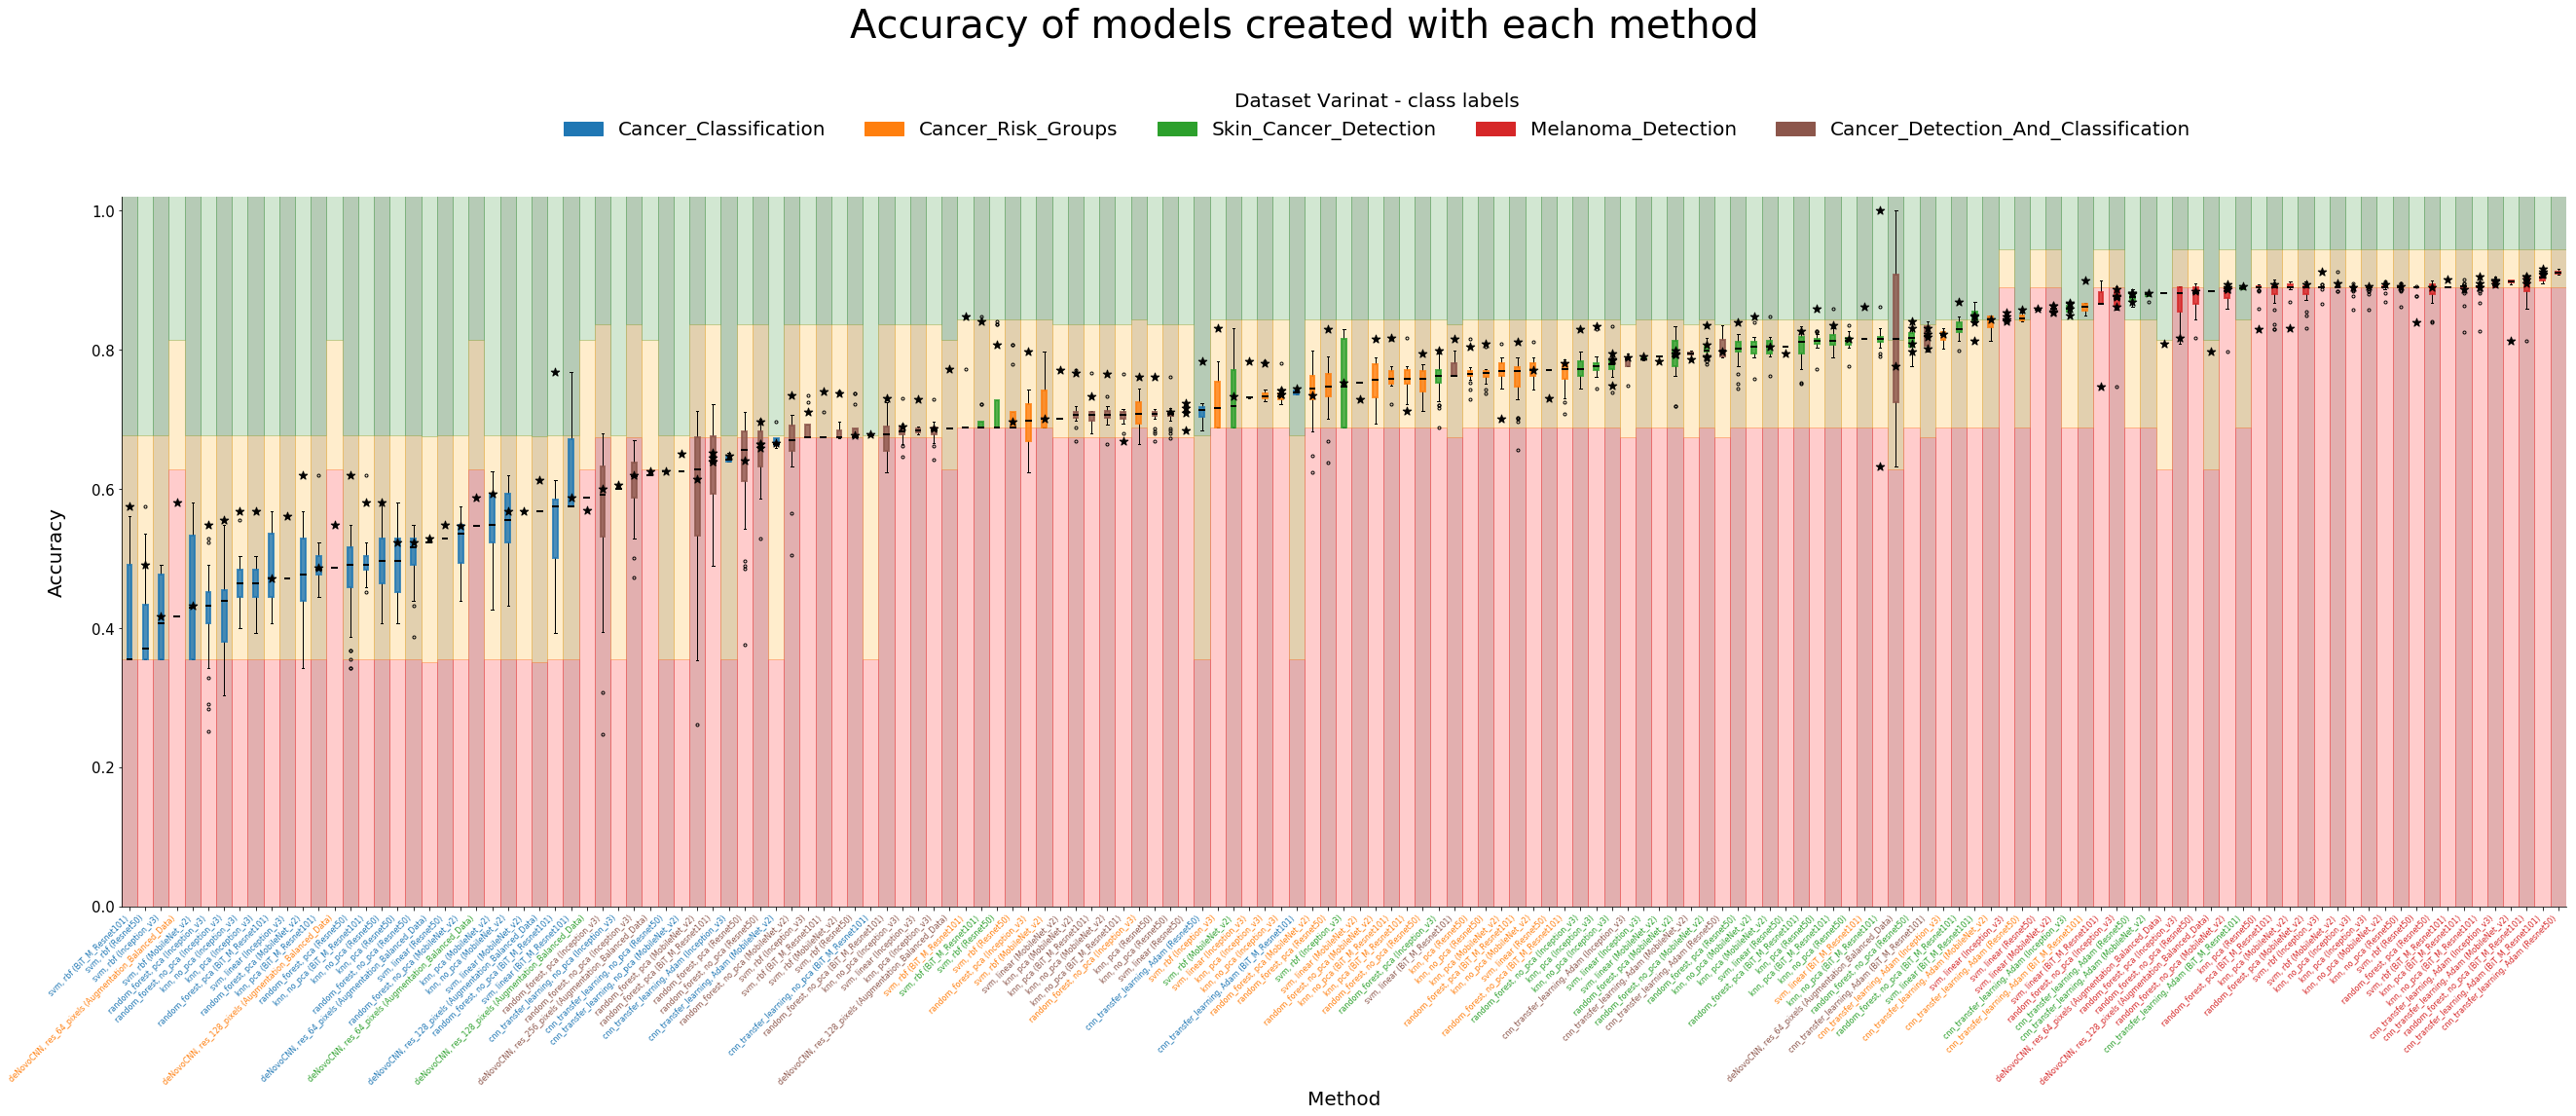

In [7]:
new_method_comparison_boxplot(                          
    title=f"Accuracy of models created with each method\n", 
    data = summary_df,#.iloc[0:500,:]         # pd.DataFrame with the results,   
    figsize=(45,15),
    # ...
    col_with_baseline      ="baseline_acc_test",
    col_with_results       ="model_acc_test",       # df colname with values to display, eg: test_accuracy ...
    col_with_group_names   ="method_name",          # df colname with values that will be displayed as names of each box (these do not have to be unique)
    col_with_group_ID      ="method_full_name",      # df colname with values that will be grouped for separate boxes (must be unieque)
    col_with_group_colors  ="dataset_variant",       # df colname with values that will have different colors (colors can not be mixed within diffeent group_ID)
    col_with_pattern       ="summary_table__file_name", # collumn that holds fule file name or its elements that indicated that a given results were made with full data or partial data
    full_data_pattern_list = ["best_models_with_all_data", "full_models", 'cnn_all_data', "deNovoCNN", "cnn_transfer_learning"],  
                                # pattern in file name that will be used to udentify models create wiht full datasets, these will be pèlotted as scatterplots
    # ... colors
    cmap="tab10",
    cmap_colors_from=0,
    cmap_colors_to=0.5,                               
    
    # .. legend
    legend_title="Dataset Varinat - class labels",
    legend__bbox_to_anchor=(0.7, 0.99),
    subplots_adjust_top = 0.8,
    legend_ncols=5,
    
    # .. baseline
    baseline_title = "",
    baseline_loc =-0.09,
    use_fixed_baselines = False,
    baseline_limit_list = [0.5, 0.9, 1.5], # the last one 
    baseline_color_list = ["red", "orange", "forestgreen"],
    
    # ... fontsizes
    title_fontsize=40,
    legend_fontsize=20,
    xticks_fontsize=8,
    yticks_fontsize=15,
    axes_labels_fontsize=20,
    
    # ... axies labels
    xaxis_label = "Method",
    yaxis_label = "Accuracy\n",
    paint_xticks=True,
    # ... scatterpoints for full models,
    add_full_models_markers =True, # if False, they are oging to be part of the barplots
    full_model_marker ="*",
    full_model_markersize=80,
    full_model_markercolor="black"
)

In [51]:
summary_df_with_stats.columns

Index(['C', 'EarlyStopping__patience', 'Unnamed: 0', 'baseline_acc_test',
       'baseline_acc_test_2', 'baseline_acc_train', 'baseline_acc_valid',
       'batch_size', 'class_weight', 'dataset_name', 'dataset_variant',
       'early_strop', 'epoch', 'f1_dropout', 'f1_units', 'fit__batch_size',
       'fit__epoch', 'gamma', 'h1_Dropout', 'h1_activation', 'h1_unit_size',
       'img_size', 'kernel', 'loss_acc_test', 'loss_acc_test_2',
       'loss_acc_train', 'loss_acc_valid', 'max_depth', 'method',
       'method_group', 'method_variant', 'metrics', 'model', 'model_ID',
       'model_acc_test', 'model_acc_test_2', 'model_acc_train',
       'model_acc_valid', 'model_loss_test', 'model_loss_test_2',
       'model_loss_train', 'model_loss_valid', 'module', 'n_estimators',
       'n_neighbors', 'optimizer', 'out_activation', 'p', 'pc', 'pca',
       'pca_components_used', 'random_state', 'random_state_nr', 'run_name',
       'summary_table__file_name', 'summary_table__path', 'unit_test',
 

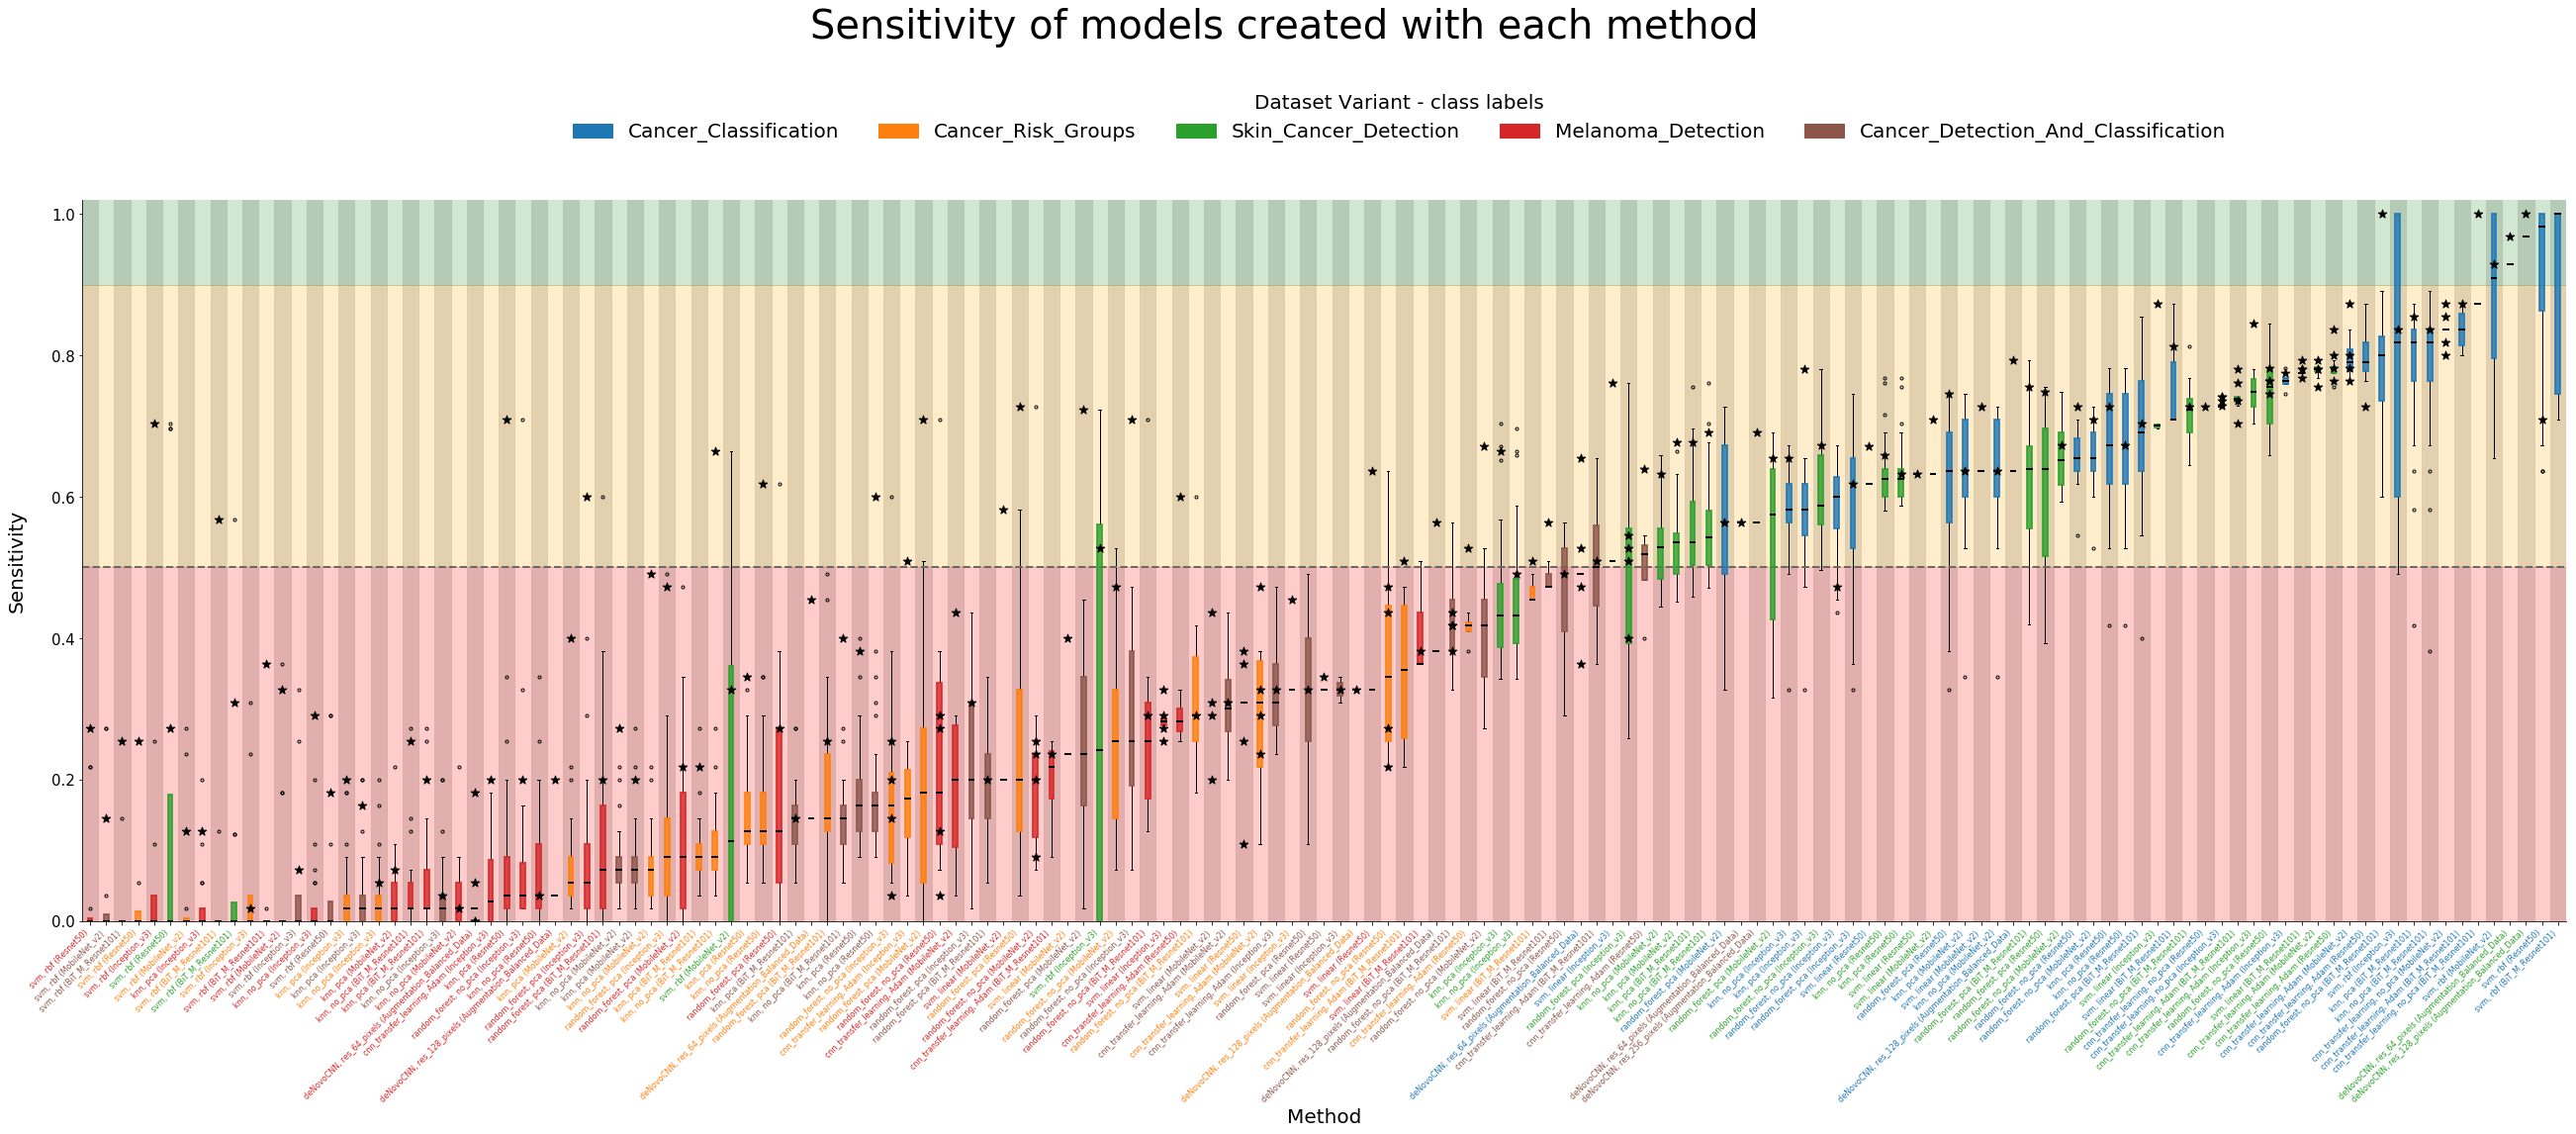

In [55]:
new_method_comparison_boxplot(                          
    title=f"Sensitivity of models created with each method\n", 
    data = summary_df_with_stats,#.iloc[0:500,:] # pd.DataFrame with the results,   
    figsize=(45,15),
    # ...
    col_with_baseline      ="baseline_acc_test",
    col_with_results       ="STATS_recall_score_test",       # df colname with values to display, eg: test_accuracy ...
    col_with_group_names   ="method_name",          # df colname with values that will be displayed as names of each box (these do not have to be unique)
    col_with_group_ID      ="method_full_name",      # df colname with values that will be grouped for separate boxes (must be unieque)
    col_with_group_colors  ="dataset_variant",       # df colname with values that will have different colors (colors can not be mixed within diffeent group_ID)
    col_with_pattern       ="summary_table__file_name", # collumn that holds fule file name or its elements that indicated that a given results were made with full data or partial data
    full_data_pattern_list = ["best_models_with_all_data", "full_models", 'cnn_all_data', "deNovoCNN", "cnn_transfer_learning"],  
                                # pattern in file name that will be used to udentify models create wiht full datasets, these will be pèlotted as scatterplots
    # ... colors
    cmap="tab10",
    cmap_colors_from=0,
    cmap_colors_to=0.5,                               
    
    # .. legend
    legend_title="Dataset Variant - class labels",
    legend__bbox_to_anchor=(0.7, 0.99),
    subplots_adjust_top = 0.8,
    legend_ncols=5,
    
    # .. baseline
    baseline_title = "",
    baseline_loc =-0.09,
    use_fixed_baselines = True,
    baseline_limit_list = [0.5, 0.9, 1.5], # the last one 
    baseline_color_list = ["red", "orange", "forestgreen"],
    
    # ... fontsizes
    title_fontsize=40,
    legend_fontsize=20,
    xticks_fontsize=8,
    yticks_fontsize=15,
    axes_labels_fontsize=20,
    
    # ... axies labels
    xaxis_label = "Method",
    yaxis_label = "Sensitivity\n",
    paint_xticks=True,
    # ... scatterpoints for full models,
    add_full_models_markers =True, # if False, they are oging to be part of the barplots
    full_model_marker ="*",
    full_model_markersize=80,
    full_model_markercolor="black"
)

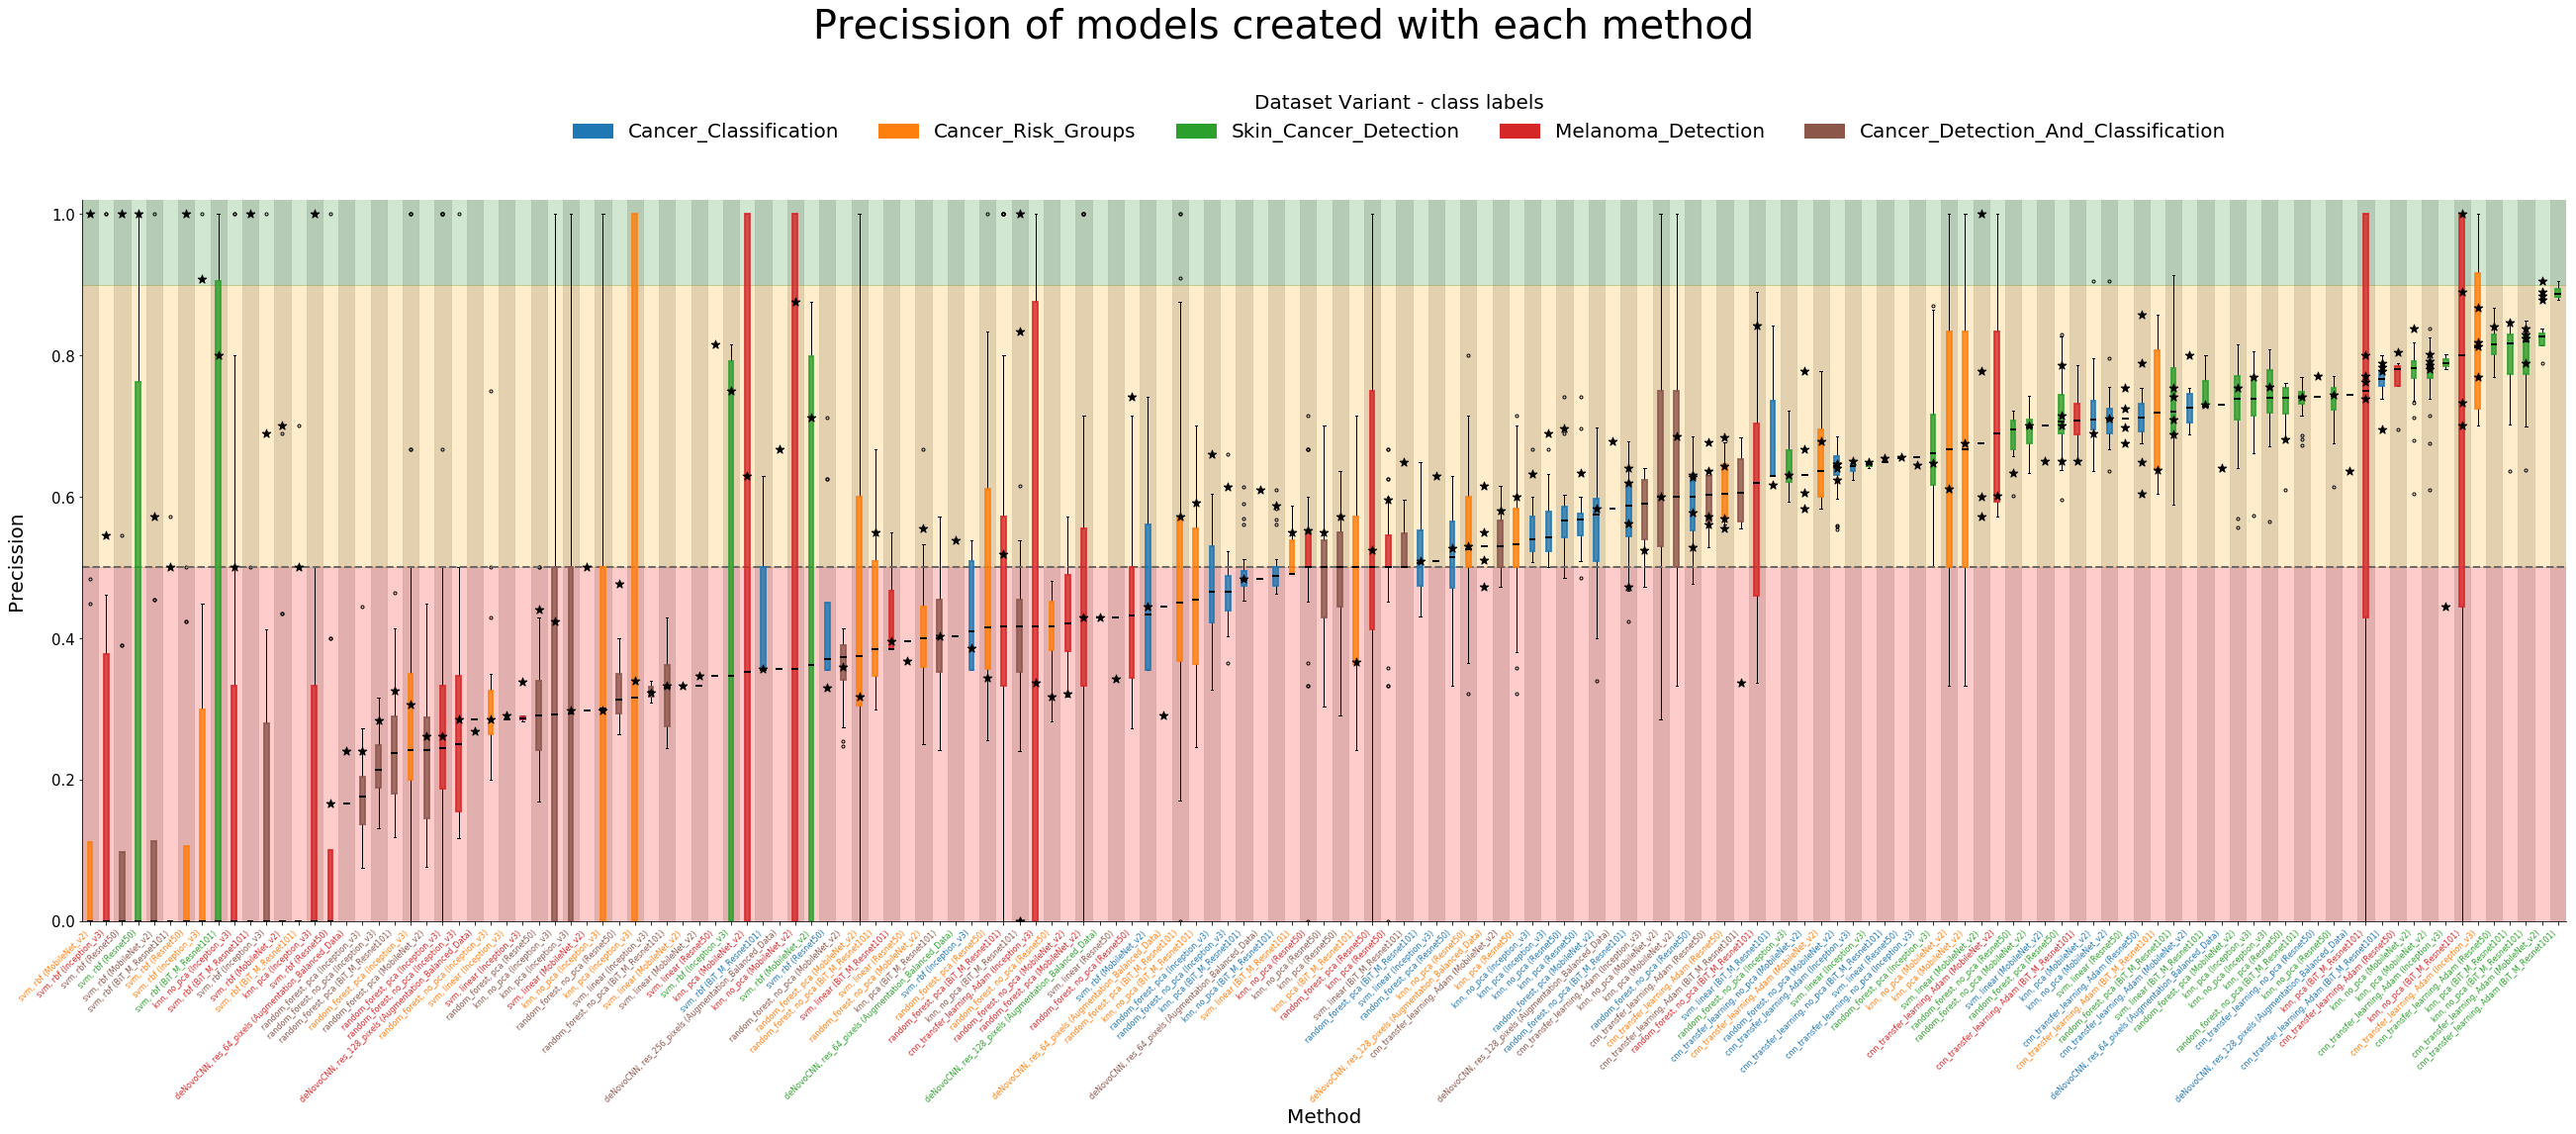

In [54]:
new_method_comparison_boxplot(                          
    title=f"Precission of models created with each method\n", 
    data = summary_df_with_stats,#.iloc[0:500,:] # pd.DataFrame with the results,   
    figsize=(45,15),
    # ...
    col_with_baseline      ="baseline_acc_test",
    col_with_results       ="STATS_precision_score_test",       # df colname with values to display, eg: test_accuracy ...
    col_with_group_names   ="method_name",          # df colname with values that will be displayed as names of each box (these do not have to be unique)
    col_with_group_ID      ="method_full_name",      # df colname with values that will be grouped for separate boxes (must be unieque)
    col_with_group_colors  ="dataset_variant",       # df colname with values that will have different colors (colors can not be mixed within diffeent group_ID)
    col_with_pattern       ="summary_table__file_name", # collumn that holds fule file name or its elements that indicated that a given results were made with full data or partial data
    full_data_pattern_list = ["best_models_with_all_data", "full_models", 'cnn_all_data', "deNovoCNN", "cnn_transfer_learning"],  
                                # pattern in file name that will be used to udentify models create wiht full datasets, these will be pèlotted as scatterplots
    # ... colors
    cmap="tab10",
    cmap_colors_from=0,
    cmap_colors_to=0.5,                               
    
    # .. legend
    legend_title="Dataset Variant - class labels",
    legend__bbox_to_anchor=(0.7, 0.99),
    subplots_adjust_top = 0.8,
    legend_ncols=5,
    
    # .. baseline
    baseline_title = "",
    baseline_loc =-0.09,
    use_fixed_baselines = True,
    baseline_limit_list = [0.5, 0.9, 1.5], # the last one 
    baseline_color_list = ["red", "orange", "forestgreen"],
    
    # ... fontsizes
    title_fontsize=40,
    legend_fontsize=20,
    xticks_fontsize=8,
    yticks_fontsize=15,
    axes_labels_fontsize=20,
    
    # ... axies labels
    xaxis_label = "Method",
    yaxis_label = "Precission\n",
    paint_xticks=True,
    # ... scatterpoints for full models,
    add_full_models_markers =True, # if False, they are oging to be part of the barplots
    full_model_marker ="*",
    full_model_markersize=80,
    full_model_markercolor="black"
)

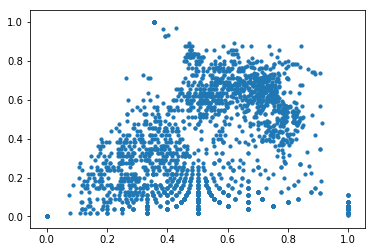

In [57]:
plt.scatter(summary_df_with_stats.STATS_precision_score_test, summary_df_with_stats.STATS_recall_score_test, s=10)